# Homework 04

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import activations
import datetime

## 1. Dataset

In [6]:
def convertData(data):
    # splits the dataset in images and labels
    images = [point[0] for point in data]
    labels = [point[1] for point in data]

    # resize all images so they are of equal shape, then casts map object back to list
    images = map(lambda img : tf.image.resize(img, [140, 140], antialias=False), images)
    images = list(images)

    # turns labels list into dataset in order to one hot encode its elements
    labels = tf.data.Dataset.from_tensor_slices(labels)
    labels = labels.map(lambda lab : tf.one_hot(lab, 2))
    
    # turns images list into dataset in order to zip images and labels back together
    images = tf.data.Dataset.from_tensor_slices(images)

    # zips images and labels back together, shuffles the dataset, takes batches of size 64 and prefeteches
    dataset = tf.data.Dataset.zip((images, labels))
    dataset = dataset.shuffle(buffer_size=64)
    dataset = dataset.batch(64)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [7]:
# load train and test datasets, using first 80% of data for training and last 20% for testing
train_data = tfds.load(name = 'malaria', split = 'train[:80%]', try_gcs = True, as_supervised = True)
test_data = tfds.load(name='malaria', split = 'train[20%:]', try_gcs= True, as_supervised=True)

# preprocess training and test data through input pipeline
train_dataset_final = convertData(train_data)
test_dataset_final = convertData(test_data)

## 2. Model

In [8]:
from tensorflow.keras.layers import Layer

class Model(Layer):
    def __init__(self):
        super(Model, self).__init__()
        
        # rescales the pixel value by dividing them by 255
        self.preproc = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(140, 140, 3))
        
        # implements 3 conv. layers with doubling number of filters (32, 64, 128) and constant kernel size (3,3)
        self.conv_layer_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu)
        # each conv. layer is followed by a pooling layer with default parameters
        self.pool_layer_1 = tf.keras.layers.MaxPooling2D()
        self.conv_layer_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu)
        self.pool_layer_2 = tf.keras.layers.MaxPooling2D()
        self.conv_layer_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu)
        self.pool_layer_3 = tf.keras.layers.MaxPooling2D()
        
        # flattens output from last pooling layer in order to use it in dense layers
        self.flatten = tf.keras.layers.Flatten()
        
        # implements two hidden layer, seperated by a dropout layer (to reduce overfitting)
        self.hidden1 = tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu)
        self.drop1 = tf.keras.layers.Dropout(rate=0.3)
        self.hidden2 = tf.keras.layers.Dense(units=512, activation=tf.keras.activations.relu)
       
        # output layer has 2 neurons (infecteed or not infected)
        self.output_layer = tf.keras.layers.Dense(units=2,activation=tf.keras.activations.softmax)
  
    def call(self, x):
        # defines the forward step
        x = self.preproc(x)
        x = self.conv_layer_1(x)
        x = self.pool_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.pool_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.pool_layer_3(x)
        x = self.flatten(x)
        x = self.hidden1(x)
        x = self.drop1(x)
        x = self.hidden2(x)
        x = self.output_layer(x)
        return x

## 3. Training

In [9]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [10]:
def calculateTime(epochs, time_passed, number_of_epochs):
    epochs = epochs + 1
    time_per_epoch = time_passed / epochs
    number = number_of_epochs - epochs
    time_sec = number * time_per_epoch
    time_remain = str(datetime.timedelta(seconds=time_sec))
    return time_remain

In [11]:
tf.keras.backend.clear_session()
import time

### Hyperparameters
num_epochs = 25
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: binary cross entropy
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters, using set learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin

test_loss, test_accuracy = test(model, test_dataset_final, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset_final, cross_entropy_loss)
train_losses.append(train_loss)

start = time.time()

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    epoch_start = time.time()
    print('Epoch: __ ' + str(epoch))

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset_final:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset_final, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print("Time until training is finished: ", calculateTime(epoch, time.time()-start, num_epochs))
  

Epoch: __ 0
Time until training is finished:  2:49:03.215309
Epoch: __ 1
Time until training is finished:  2:42:01.322774
Epoch: __ 2
Time until training is finished:  2:33:38.935570
Epoch: __ 3
Time until training is finished:  2:25:44.242885
Epoch: __ 4
Time until training is finished:  2:18:19.426075
Epoch: __ 5
Time until training is finished:  2:10:52.790613
Epoch: __ 6
Time until training is finished:  2:03:34.131364
Epoch: __ 7
Time until training is finished:  1:56:30.356538
Epoch: __ 8
Time until training is finished:  1:49:25.884112
Epoch: __ 9
Time until training is finished:  1:42:25.056294
Epoch: __ 10
Time until training is finished:  1:35:28.823760
Epoch: __ 11
Time until training is finished:  1:28:35.003805
Epoch: __ 12
Time until training is finished:  1:21:41.314017
Epoch: __ 13
Time until training is finished:  1:14:48.145665
Epoch: __ 14
Time until training is finished:  1:07:56.369243
Epoch: __ 15
Time until training is finished:  1:01:05.741939
Epoch: __ 16
Time 

## 4. Visualization

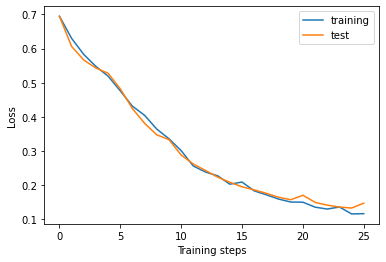

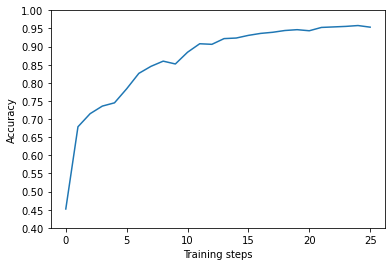

Highest accuracy:  0.9581068840579711


In [12]:
# Visualize accuracy and loss for training and test data. 
# Plot training and test loss.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot test accuracy
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.yticks(np.arange(0.4, 1.05, 0.05))
plt.ylabel("Accuracy")
plt.show()
print("Highest accuracy: ", max(test_accuracies))